 - note on binarize (example?)
 - matrix vs array treatment
 - shapes and sizes hangups

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

data = pd.read_csv('data.txt')

X = data.as_matrix(columns=['alcohol', 'ash'])
y = label_binarize(data['class'], [1, 2, 3])[:,0]

- train / test sets

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('train:', len(X_train), 'test:', len(X_test))

train: 142 test: 36


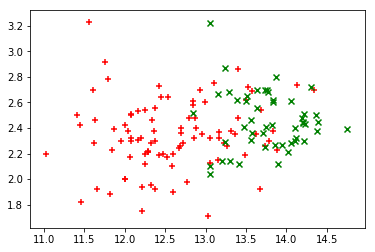

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

plot_points(X_train, y_train)

In [4]:
import numpy as np
from scipy.optimize import fmin_tnc  

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def cost(theta, X, y):
    y = np.asmatrix(y).T
    theta = np.asmatrix(theta).T
    
    h = sigmoid(X * theta)
    pos = np.multiply(-y, np.log(h))
    neg = np.multiply((1 - y), np.log(1 - h))
    j = np.sum(pos - neg) / (len(X))
    
    return j

def gradient(theta, X, y):
    theta = np.asmatrix(theta).T
    y = np.asmatrix(y).T
    
    error = sigmoid(X * theta) - y
    grad = X.T * error / len(X)
    
    return grad

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    result = fmin_tnc(func=cost, x0=np.zeros(3), fprime=gradient, args=(X, y))
    return result[0]

theta = train(X_train, y_train)
print('theta: ', theta)

theta:  [-45.72353544   3.22363629   0.97681784]


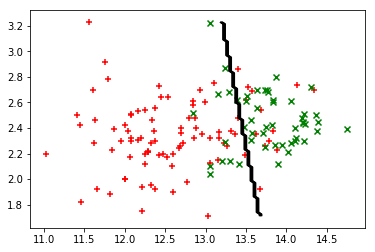

In [5]:
from matplotlib import cm

def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min(), X[:,0].max()
    y_min, y_max = X[:,1].min(), X[:,1].max()
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)

    plt.contour(xs, ys, zs, colors='black')
    
def predict(X, theta):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    return sigmoid(X * np.matrix(theta).T) >= 0.5
    
plot_points(X_train, y_train)
plot_boundary(X_train, lambda x: predict(x, theta))

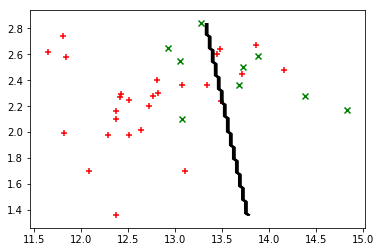

In [6]:
plot_boundary(X_test, lambda x: predict(x, theta))
plot_points(X_test, y_test)

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

predictions = predict(X_test, theta)

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.75
precision: 0.673076923077
recall: 0.685185185185


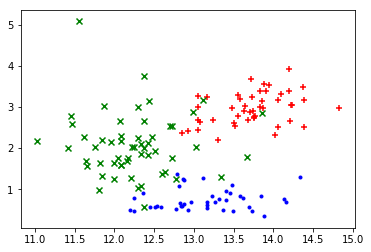

In [14]:
X = data.as_matrix(columns=['alcohol', 'flavanoids'])
y = data.as_matrix(columns=['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = label_binarize(y_train, [1, 2, 3])

plot_points(X_train, y_train.argmax(axis=1))

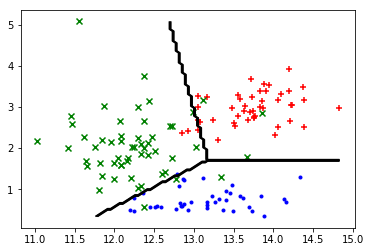

In [19]:
def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    result = fmin_tnc(func=cost, x0=np.zeros(3), fprime=gradient, args=(X, y))
    return np.matrix(result[0])

def predict_multilabel(X, thetas):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    preds = [sigmoid(X * np.asmatrix(t).T) for t in thetas]
    return np.column_stack(preds).argmax(axis=1)

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]

plot_points(X_train, y_train.argmax(axis=1))
plot_boundary(X_train, lambda x: predict_multilabel(x, thetas))

In [10]:
predictions = predict_multilabel(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.888888888889
precision: 0.872727272727
recall: 0.900178253119


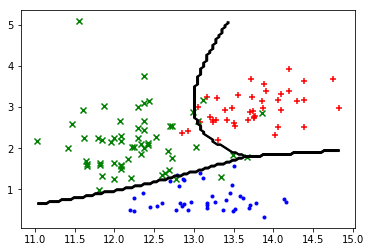

In [11]:
def transform(x):
    return [x[0], x[1], x[0] ** 2, x[1] ** 2, x[0] * x[1]]

def train(X, y):
    
    X = np.insert(X, 0, np.ones(len(X)), axis=1)

    #print(X)
    result = fmin_tnc(func=cost, x0=np.zeros(6), fprime=gradient, args=(X, y))
    return np.matrix(result[0])

def xplot(X):
    return np.apply_along_axis(transform, 1, X)

X_train_m = np.apply_along_axis(transform, 1, X_train)
thetas = [train(X_train_m, y_train[:,i]) for i in range(0,3)]

plot_points(X_train_m, y_train.argmax(axis=1))
plot_boundary(X_train_m, lambda x: predict_multilabel(xplot(x), thetas))

In [12]:
predictions = predict_multilabel(xplot(X_test), thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.888888888889
precision: 0.872053872054
recall: 0.889483065954


In [13]:
X = data.drop('class', 1).as_matrix()
y = data.as_matrix(columns=['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = label_binarize(y_train, [1, 2, 3])

def cost_reg(theta, X, y, l):
    return cost(theta, X, y) + np.square(theta).sum() / (2 * len(X))

def gradient2(theta, X, y, l):
    return gradient(theta, X, y) + np.matrix(theta).T / len(X)

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    return fmin_tnc(func=cost_reg, x0=np.zeros(14), fprime=gradient2, args=(X, y, 1.0))[0]

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
predictions = predict_multilabel(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.916666666667
precision: 0.92673992674
recall: 0.92673992674
